In [2]:
pip install wordcloud

     |████████████████████████████████| 172 kB 3.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install colorcet


     |████████████████████████████████| 260 kB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import *
from src.data.clean_data import *
from src.utils.data_utils import *
from src.utils.plot_utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdulkarimmouakeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

Loading data from data/raw/TMDB_movie_dataset_v11.csv...
original df shape (1131296, 24)
after status (1105740, 24)
after adult (1000597, 24)
after release date (670458, 24)
after release year (670458, 25)
after runtime (457363, 25)
after duplicates (453627, 25)
after numeric columns (453627, 25)
after select columns (453627, 13)
Loading data from data/raw/movie.metadata.tsv...
original df shape (81740, 9)
after release year (44006, 9)
after runtime (34490, 9)
after duplicates (34435, 9)
after numeric columns (34435, 9)
after select columns (34435, 5)
Loading data from data/raw/plot_summaries.txt...


In [5]:

df_tmdb = create_tmdb_dataset('data/processed/TMDB_clean.csv')

In [6]:
df_tmdb.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,Inception,2010-07-15,825532764,148,160000000,en,"Cobb, a skilled thief who commits corporate es...","[Action, Science Fiction, Adventure]","[Legendary Pictures, Syncopy, Warner Bros. Pic...","[United Kingdom, United States of America]","[English, French, Japanese, Swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,post
1,Interstellar,2014-11-05,701729206,169,165000000,en,The adventures of a group of explorers who mak...,"[Adventure, Drama, Science Fiction]","[Legendary Pictures, Syncopy, Lynda Obst Produ...","[United Kingdom, United States of America]",[English],"[rescue, future, spacecraft, race against time...",2014,post
2,The Dark Knight,2008-07-16,1004558444,152,185000000,en,Batman raises the stakes in his war on crime. ...,"[Drama, Action, Crime, Thriller]","[DC Comics, Legendary Pictures, Syncopy, Isobe...","[United Kingdom, United States of America]","[English, Mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,post
3,Avatar,2009-12-15,2923706026,162,237000000,en,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[Dune Entertainment, Lightstorm Entertainment,...","[United States of America, United Kingdom]","[English, Spanish]","[future, society, culture clash, space travel,...",2009,post
4,The Avengers,2012-04-25,1518815515,143,220000000,en,When an unexpected enemy emerges and threatens...,"[Science Fiction, Action, Adventure]",[Marvel Studios],[United States of America],"[English, Hindi, Russian]","[new york city, superhero, shield, based on co...",2012,post


In [7]:
unique_dvd_era = df_tmdb['dvd_era'].unique()


print("Unique values in the 'dvd_era' column:")
print(unique_dvd_era)

Unique values in the 'dvd_era' column:
['post' 'during' 'pre']


In [8]:
movies_per_era = df_tmdb['dvd_era'].value_counts()

print("Number of movies per DVD era:")
print(movies_per_era)

Number of movies per DVD era:
post      207460
pre        83908
during     70931
Name: dvd_era, dtype: int64


In [9]:
unique_genres = pd.Series([genre for genres in df_tmdb['genres'] for genre in genres]).unique()


print("Unique Genres:")
print(unique_genres)

Unique Genres:
['Action' 'Science Fiction' 'Adventure' 'Drama' 'Crime' 'Thriller'
 'Fantasy' 'Comedy' 'Romance' 'Western' 'Mystery' 'War' 'Animation'
 'Family' 'Horror' 'Music' 'History' 'TV Movie']


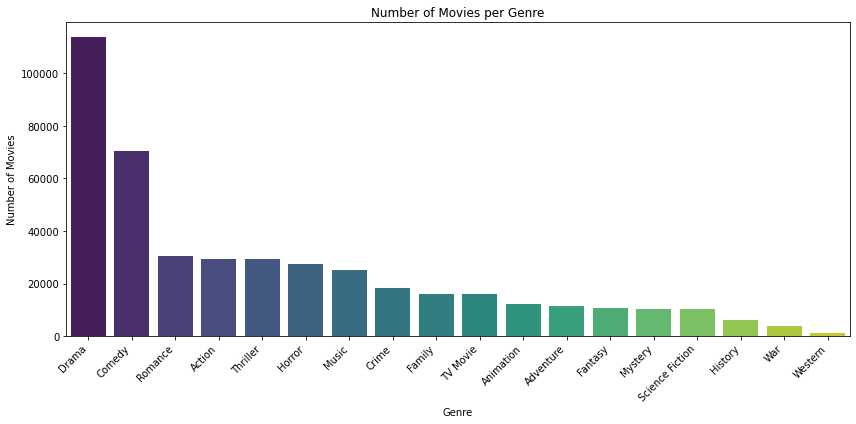

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


genre_counts = pd.Series([genre for genres in df_tmdb['genres'] for genre in genres]).value_counts()


plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


plt.show()

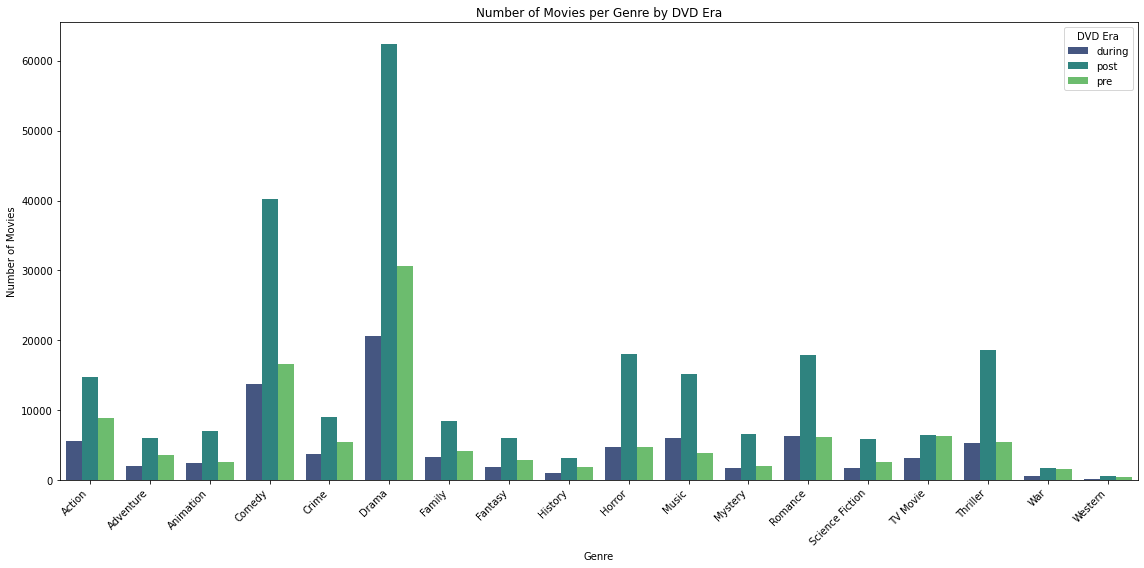

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_exploded = df_tmdb.explode('genres')


genre_counts_per_era = df_exploded.groupby(['dvd_era', 'genres']).size().reset_index(name='count')


plt.figure(figsize=(16, 8))
sns.barplot(data=genre_counts_per_era, x='genres', y='count', hue='dvd_era', palette='viridis')

plt.title('Number of Movies per Genre by DVD Era')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.legend(title='DVD Era')
plt.tight_layout()


plt.show()

there are alot of movies produced after the dvd era so we cant take that into consideration when comparing eras of the genres, so we are going to focus on the pre dvd and during dvd era

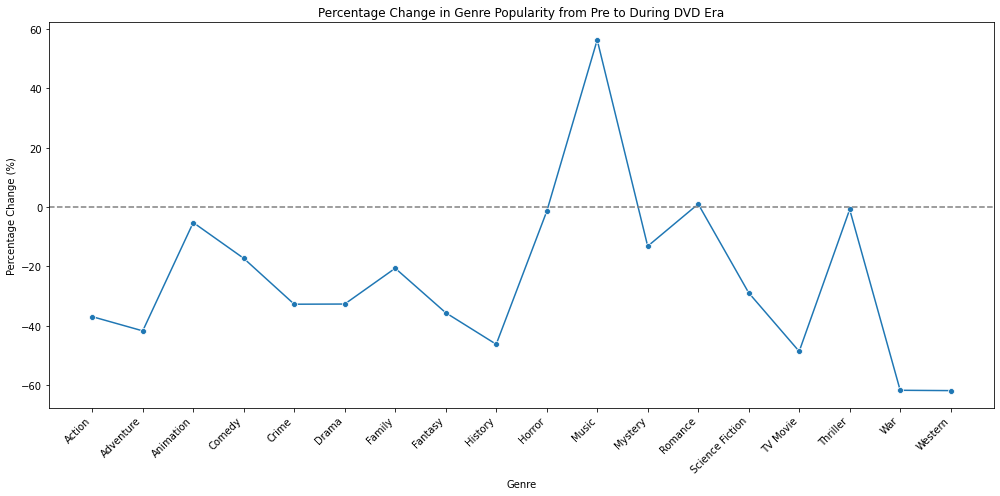

In [12]:
df_exploded = df_tmdb.explode('genres')


genre_counts_per_era = df_exploded.groupby(['dvd_era', 'genres']).size().reset_index(name='count')


genre_counts_pivot = genre_counts_per_era.pivot(index='genres', columns='dvd_era', values='count').fillna(0)


genre_counts_pivot['percentage_change_pre_to_during'] = (
    (genre_counts_pivot['during'] - genre_counts_pivot['pre']) / genre_counts_pivot['pre'].replace(0, pd.NA)
) * 100

genre_counts_pivot = genre_counts_pivot.dropna(subset=['percentage_change_pre_to_during'])


plt.figure(figsize=(14, 7))
sns.lineplot(
    data=genre_counts_pivot.reset_index(),
    x='genres',
    y='percentage_change_pre_to_during',
    marker='o'
)


plt.title('Percentage Change in Genre Popularity from Pre to During DVD Era')
plt.xlabel('Genre')
plt.ylabel('Percentage Change (%)')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')  
plt.tight_layout()


plt.show()


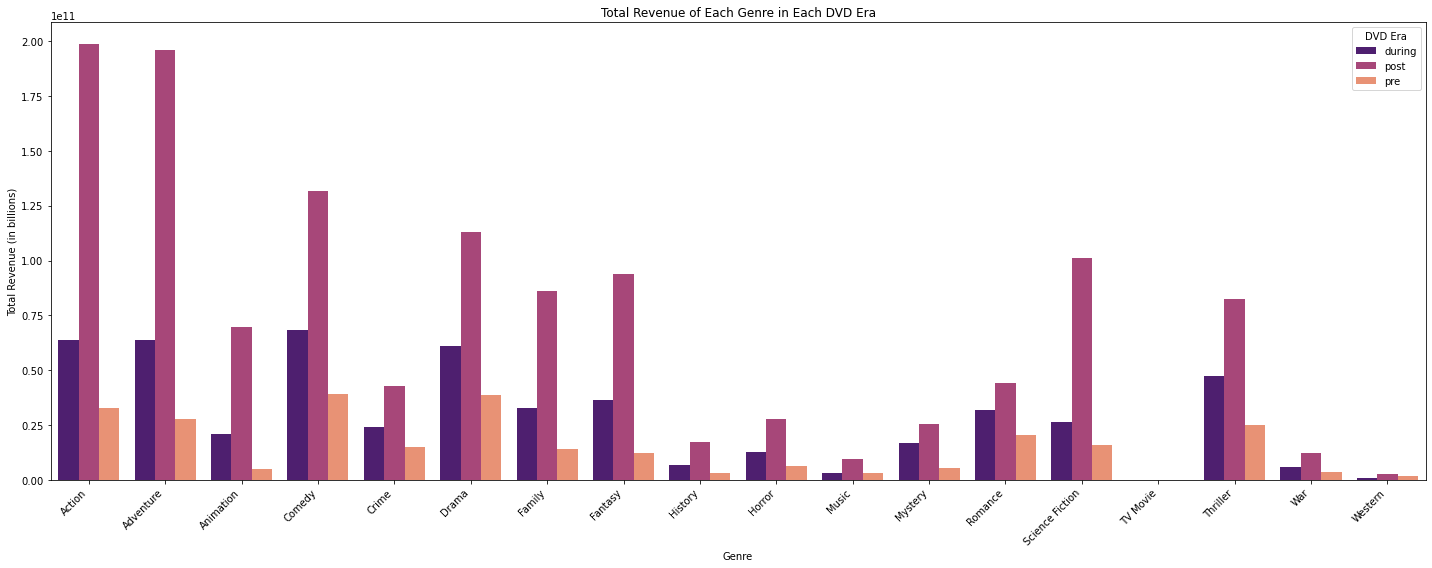

In [13]:
df_exploded = df_tmdb.explode('genres')

revenue_per_genre_era = df_exploded.groupby(['dvd_era', 'genres'])['revenue'].sum().reset_index()


plt.figure(figsize=(20, 8))
sns.barplot(
    data=revenue_per_genre_era,
    x='genres',
    y='revenue',
    hue='dvd_era',
    palette='magma'
)


plt.title('Total Revenue of Each Genre in Each DVD Era')
plt.xlabel('Genre')
plt.ylabel('Total Revenue (in billions)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='DVD Era')
plt.tight_layout()


plt.show()


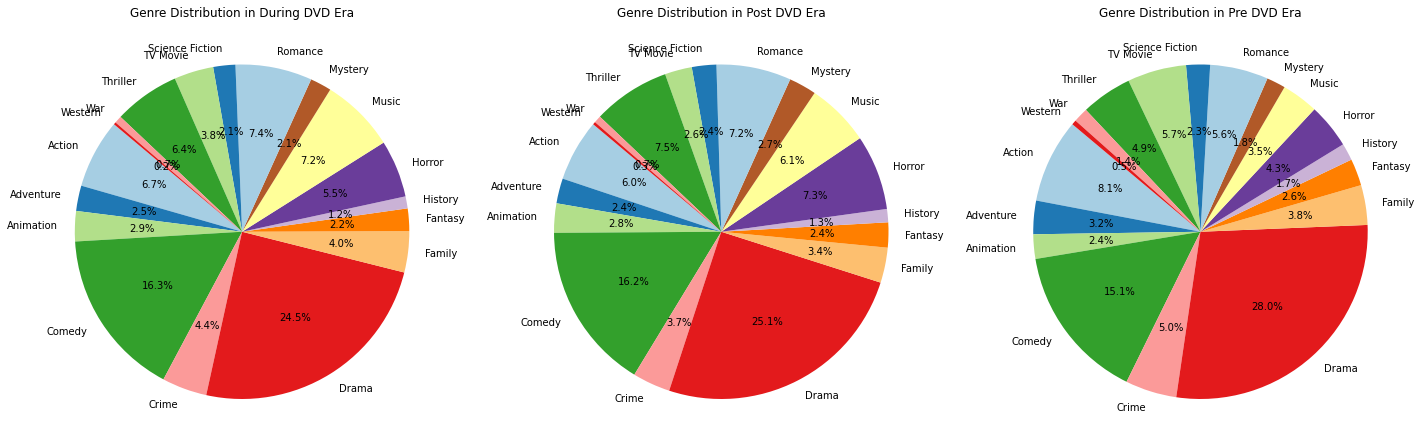

In [14]:
df_exploded = df_tmdb.explode('genres')

genre_counts_per_era = df_exploded.groupby(['dvd_era', 'genres']).size().reset_index(name='count')

total_movies_per_era = genre_counts_per_era.groupby('dvd_era')['count'].sum().reset_index(name='total_count')

genre_counts_per_era = genre_counts_per_era.merge(total_movies_per_era, on='dvd_era')
genre_counts_per_era['percentage'] = (genre_counts_per_era['count'] / genre_counts_per_era['total_count']) * 100

eras = genre_counts_per_era['dvd_era'].unique()
plt.figure(figsize=(20, 10))

for i, era in enumerate(eras):
    plt.subplot(1, len(eras), i + 1)
    data = genre_counts_per_era[genre_counts_per_era['dvd_era'] == era]
    plt.pie(
        data['percentage'],
        labels=data['genres'],
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Paired.colors
    )
    plt.title(f'Genre Distribution in {era.capitalize()} DVD Era')

plt.tight_layout()
plt.show()


# P3

# Subquestion 1 

In [15]:
genre_proportions = pd.DataFrame()


for genre in unique_genres:
    
    genre_counts = df_tmdb[df_tmdb['genres'].apply(lambda x: genre in x)].groupby('dvd_era').size()
    
    genre_proportion = genre_counts / movies_per_era
    
    genre_proportions[genre] = genre_proportion


genre_proportions = genre_proportions.T


genre_proportions = genre_proportions.fillna(0)


print("Genre Proportions by DVD Era:")
print(genre_proportions)

Genre Proportions by DVD Era:
                   during      post       pre
Action           0.079232  0.071421  0.106212
Science Fiction  0.025377  0.028314  0.030164
Adventure        0.029127  0.028916  0.042284
Drama            0.291283  0.300482  0.365770
Crime            0.051726  0.043729  0.064988
Thriller         0.075693  0.089444  0.064511
Fantasy          0.025856  0.028994  0.033942
Comedy           0.193399  0.193734  0.197609
Romance          0.088001  0.086407  0.073640
Western          0.002679  0.003157  0.005935
Mystery          0.024531  0.031866  0.023883
War              0.008417  0.008353  0.018628
Animation        0.034696  0.033847  0.030939
Family           0.047257  0.040615  0.050329
Horror           0.065923  0.086923  0.056550
Music            0.085703  0.073301  0.046325
History          0.013788  0.015295  0.021679
TV Movie         0.045269  0.031351  0.074534


In [16]:
genre_proportions = genre_proportions[['pre', 'during', 'post']]


In [17]:
print(genre_proportions)

                      pre    during      post
Action           0.106212  0.079232  0.071421
Science Fiction  0.030164  0.025377  0.028314
Adventure        0.042284  0.029127  0.028916
Drama            0.365770  0.291283  0.300482
Crime            0.064988  0.051726  0.043729
Thriller         0.064511  0.075693  0.089444
Fantasy          0.033942  0.025856  0.028994
Comedy           0.197609  0.193399  0.193734
Romance          0.073640  0.088001  0.086407
Western          0.005935  0.002679  0.003157
Mystery          0.023883  0.024531  0.031866
War              0.018628  0.008417  0.008353
Animation        0.030939  0.034696  0.033847
Family           0.050329  0.047257  0.040615
Horror           0.056550  0.065923  0.086923
Music            0.046325  0.085703  0.073301
History          0.021679  0.013788  0.015295
TV Movie         0.074534  0.045269  0.031351


In [18]:
import matplotlib.pyplot as plt

def create_genre_proportions_plot(genre_proportions):
   
    
    plt.figure(figsize=(12, 8))
    
  
    for genre in genre_proportions.index:
        plt.plot(genre_proportions.columns, genre_proportions.loc[genre], label=genre)
    
 
    plt.title("Proportion of Genres Over DVD Eras", fontsize=16)
    plt.xlabel("DVD Era", fontsize=14)
    plt.ylabel("Proportion", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
  
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    
    plt.show()


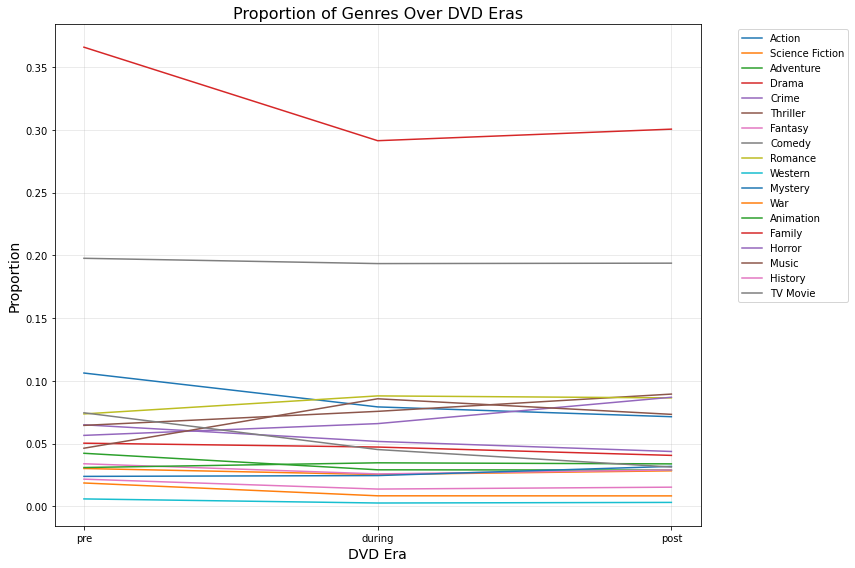

In [19]:
create_genre_proportions_plot(genre_proportions)

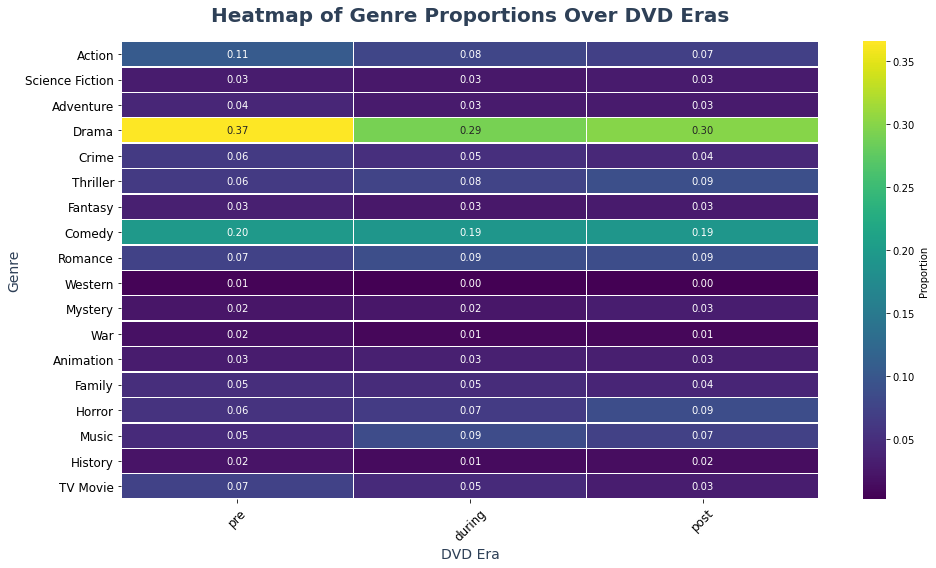

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_genre_proportions_heatmap(genre_proportions):
    
    plt.figure(figsize=(14, 8))
    
    
    sns.heatmap(
        genre_proportions,
        annot=True,  
        fmt=".2f",  
        cmap="viridis",  
        cbar_kws={'label': 'Proportion'},  
        linewidths=0.5,  
        linecolor='white'  
    )
    
 
    plt.title("Heatmap of Genre Proportions Over DVD Eras", fontsize=20, weight='bold', pad=20, color='#2E4057')
    plt.xlabel("DVD Era", fontsize=14, color='#2E4057')
    plt.ylabel("Genre", fontsize=14, color='#2E4057')
    
    
    plt.xticks(fontsize=12, rotation=45)  
    plt.yticks(fontsize=12)  
    
    
    plt.tight_layout()
    plt.show()


create_genre_proportions_heatmap(genre_proportions)


In [21]:
import scipy.stats as stats


contingency_table = pd.DataFrame(index=unique_genres, columns=['pre', 'during', 'post'], dtype=int)

for genre in unique_genres:
    contingency_table.loc[genre, 'pre'] = df_tmdb[(df_tmdb['dvd_era'] == 'pre') & (df_tmdb['genres'].apply(lambda x: genre in x))].shape[0]
    contingency_table.loc[genre, 'during'] = df_tmdb[(df_tmdb['dvd_era'] == 'during') & (df_tmdb['genres'].apply(lambda x: genre in x))].shape[0]
    contingency_table.loc[genre, 'post'] = df_tmdb[(df_tmdb['dvd_era'] == 'post') & (df_tmdb['genres'].apply(lambda x: genre in x))].shape[0]

print("Contingency Table (Genre Counts by DVD Era):")
print(contingency_table)


Contingency Table (Genre Counts by DVD Era):
                     pre   during     post
Action            8912.0   5620.0  14817.0
Science Fiction   2531.0   1800.0   5874.0
Adventure         3548.0   2066.0   5999.0
Drama            30691.0  20661.0  62338.0
Crime             5453.0   3669.0   9072.0
Thriller          5413.0   5369.0  18556.0
Fantasy           2848.0   1834.0   6015.0
Comedy           16581.0  13718.0  40192.0
Romance           6179.0   6242.0  17926.0
Western            498.0    190.0    655.0
Mystery           2004.0   1740.0   6611.0
War               1563.0    597.0   1733.0
Animation         2596.0   2461.0   7022.0
Family            4223.0   3352.0   8426.0
Horror            4745.0   4676.0  18033.0
Music             3887.0   6079.0  15207.0
History           1819.0    978.0   3173.0
TV Movie          6254.0   3211.0   6504.0


In [22]:

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)


print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")


expected_table = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("\nExpected Frequencies:")
print(expected_table)



Chi-Square Test Results:
Chi-Square Statistic: 8143.499174361407
P-Value: 0.0
Degrees of Freedom: 34

Expected Frequencies:
                          pre        during          post
Action            7284.464268   5593.064035  16471.471697
Science Fiction   2532.895766   1944.775579   5727.328654
Adventure         2882.363404   2213.099344   6517.537252
Drama            28218.022508  21666.000552  63805.976941
Crime             4515.777126   3467.246143  10210.976730
Thriller          7281.734052   5590.967756  16465.298192
Fantasy           2655.010878   2038.536440   6003.452681
Comedy           17495.968199  13433.530169  39561.501632
Romance           7532.169312   5783.253749  17031.576939
Western            333.334543    255.936659    753.728798
Mystery           2570.125984   1973.361208   5811.512809
War                966.248233    741.892340   2184.859427
Animation         2998.025278   2301.905363   6779.069359
Family            3971.471353   3049.324257   8980.204389
Horro

In [23]:
import pandas as pd
from scipy.stats import chi2_contingency


genre_proportions = pd.DataFrame({
    'pre': [0.106212, 0.030164, 0.042284, 0.365770, 0.064988, 0.064511, 0.033942, 0.197609, 0.073640, 0.005935, 0.023883, 0.018628, 0.030939, 0.050329, 0.056550, 0.046325, 0.021679, 0.074534],
    'during': [0.079232, 0.025377, 0.029127, 0.291283, 0.051726, 0.075693, 0.025856, 0.193399, 0.088001, 0.002679, 0.024531, 0.008417, 0.034696, 0.047257, 0.065923, 0.085703, 0.013788, 0.045269],
    'post': [0.071421, 0.028314, 0.028916, 0.300482, 0.043729, 0.089444, 0.028994, 0.193734, 0.086407, 0.003157, 0.031866, 0.008353, 0.033847, 0.040615, 0.086923, 0.073301, 0.015295, 0.031351]
}, index=[
    'Action', 'Science Fiction', 'Adventure', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Comedy', 'Romance', 'Western', 'Mystery', 'War', 'Animation', 'Family', 'Horror', 'Music', 'History', 'TV Movie'
])


chi2_stat, p_value, dof, expected = chi2_contingency(genre_proportions)


print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")


expected_table = pd.DataFrame(expected, index=genre_proportions.index, columns=genre_proportions.columns)
print("\nExpected Frequencies:")
print(expected_table)



Chi-Square Test Results:
Chi-Square Statistic: 0.0746366687809152
P-Value: 1.0
Degrees of Freedom: 34

Expected Frequencies:
                      pre    during      post
Action           0.090996  0.082650  0.083220
Science Fiction  0.029706  0.026981  0.027167
Adventure        0.035541  0.032281  0.032504
Drama            0.339212  0.308099  0.310224
Crime            0.056838  0.051625  0.051981
Thriller         0.081354  0.073892  0.074402
Fantasy          0.031455  0.028570  0.028767
Comedy           0.207148  0.188148  0.189446
Romance          0.087872  0.079813  0.080363
Western          0.004170  0.003787  0.003814
Mystery          0.028440  0.025831  0.026009
War              0.012540  0.011390  0.011468
Animation        0.035242  0.032010  0.032230
Family           0.048958  0.044468  0.044775
Horror           0.074180  0.067376  0.067840
Music            0.072739  0.066067  0.066523
History          0.017983  0.016333  0.016446
TV Movie         0.053547  0.048636  0.048971


These results indicate that there is no statistically significant difference in the distribution of genres across the DVD eras when using the chi-square test. A p-value of 1.0 suggests that any changes observed in genre distribution are likely due to chance rather than a significant shift over time. This outcome implies that the proportions of genres did not change significantly across the eras examined (pre, during, and post).

# Subquestion 2

In [24]:

sorted_data = df_tmdb.sort_values('revenue', ascending=False)


top_10_percent_index = int(len(sorted_data) * 0.10)
top_10_percent_data = sorted_data.head(top_10_percent_index)


top_10_percent_data.head()


,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
3,Avatar,2009-12-15,2923706026,162,237000000,en,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[Dune Entertainment, Lightstorm Entertainment,...","[United States of America, United Kingdom]","[English, Spanish]","[future, society, culture clash, space travel,...",2009,post
15,Avengers: Endgame,2019-04-24,2800000000,181,356000000,en,After the devastating events of Avengers: Infi...,"[Adventure, Science Fiction, Action]",[Marvel Studios],[United States of America],"[English, Japanese, Xhosa]","[superhero, time travel, space travel, time ma...",2019,post
278,Avatar: The Way of Water,2022-12-14,2320250281,192,460000000,en,Set more than a decade after the events of the...,"[Science Fiction, Adventure, Action]","[20th Century Studios, Lightstorm Entertainment]",[United States of America],[English],"[dying and death, loss of loved one, alien lif...",2022,post
17,Titanic,1997-11-18,2264162353,194,200000000,en,101-year-old Rose DeWitt Bukater tells the sto...,"[Drama, Romance]","[Paramount, 20th Century Fox, Lightstorm Enter...",[United States of America],"[English, French, German, Swedish, Italian, Ru...","[epic, ship, drowning, panic, shipwreck, evacu...",1997,during
55,Star Wars: The Force Awakens,2015-12-15,2068223624,136,245000000,en,Thirty years after defeating the Galactic Empi...,"[Adventure, Action, Science Fiction]","[Lucasfilm Ltd., Bad Robot]",[United States of America],[English],"[android, spacecraft, space opera]",2015,post


In [31]:
import ast  

top_10_percent_data['genres'] = top_10_percent_data['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


top_10_percent_exploded = top_10_percent_data.explode('genres')


genre_mean_revenues = (
    top_10_percent_exploded
    .groupby(['dvd_era', 'genres'])['revenue']
    .mean()
    .reset_index()
    .rename(columns={'genres': 'genre', 'revenue': 'mean_revenue'})
)


genre_mean_revenues_pivot = genre_mean_revenues.pivot_table(
    index='dvd_era', 
    columns='genre', 
    values='mean_revenue', 
    aggfunc='mean'
)


genre_mean_revenues_pivot = genre_mean_revenues_pivot.reset_index()


genre_mean_revenues_pivot.head()


<ipython-input-31-c041ab6236ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_percent_data['genres'] = top_10_percent_data['genres'].apply(


genre,dvd_era,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,during,7.199782e+07,1.247862e+08,6.990715e+07,3.702537e+07,3.752270e+07,2.352235e+07,6.784321e+07,9.638928e+07,4.293740e+07,2.033282e+07,7.330714e+06,4.913904e+07,3.412674e+07,8.560411e+07,1.023430e+06,4.957956e+07,5.529195e+07,3.127576e+07
1,post,8.519381e+07,1.483727e+08,7.169022e+07,2.977606e+07,3.458943e+07,1.707698e+07,8.075797e+07,1.012948e+08,3.367196e+07,1.404565e+07,8.117455e+06,3.054751e+07,2.342009e+07,1.217783e+08,2.678768e+05,3.624802e+07,4.336778e+07,3.714022e+07
2,pre,3.069773e+07,5.246005e+07,1.374726e+07,1.900307e+07,2.166379e+07,1.200093e+07,2.657964e+07,2.962795e+07,1.523257e+07,1.161643e+07,8.783211e+06,2.160027e+07,2.179862e+07,4.340625e+07,1.330521e+05,3.331437e+07,2.432689e+07,3.915807e+07


In [35]:

adjustment_factors = {
    'during_to_pre': 0.91,  
    'post_to_pre': 0.73     
}


for genre in genre_mean_revenues_pivot.columns[1:]:  
    genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'during', genre] *= adjustment_factors['during_to_pre']
    genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'post', genre] *= adjustment_factors['post_to_pre']


genre_mean_revenues_pivot.head()



genre,dvd_era,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,during,5.962139e+07,1.033354e+08,5.789011e+07,3.066071e+07,3.107255e+07,1.947886e+07,5.618096e+07,7.981996e+07,3.555646e+07,1.683761e+07,6.070564e+06,4.069204e+07,2.826035e+07,7.088876e+07,847502.610223,4.105683e+07,4.578726e+07,2.589945e+07
1,post,4.539978e+07,7.906782e+07,3.820372e+07,1.586766e+07,1.843271e+07,9.100322e+06,4.303592e+07,5.397998e+07,1.794379e+07,7.484929e+06,4.325792e+06,1.627877e+07,1.248056e+07,6.489567e+07,142751.526597,1.931657e+07,2.311069e+07,1.979202e+07
2,pre,3.069773e+07,5.246005e+07,1.374726e+07,1.900307e+07,2.166379e+07,1.200093e+07,2.657964e+07,2.962795e+07,1.523257e+07,1.161643e+07,8.783211e+06,2.160027e+07,2.179862e+07,4.340625e+07,133052.123418,3.331437e+07,2.432689e+07,3.915807e+07


In [38]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [44]:
import plotly.graph_objects as go

def create_genre_contributions_plot(genre_mean_revenues_pivot):
    
    # Set up the figure
    fig = go.Figure()

    
    pre_values = genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'pre'].iloc[0, 1:]
    during_values = genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'during'].iloc[0, 1:]
    post_values = genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'post'].iloc[0, 1:]

    genres = genre_mean_revenues_pivot.columns[1:]

    # Add bar traces for each era
    fig.add_trace(
        go.Bar(
            x=genres, 
            y=pre_values, 
            name='Pre Era',
            marker=dict(color='blue')
        )
    )
    fig.add_trace(
        go.Bar(
            x=genres, 
            y=during_values, 
            name='During Era',
            marker=dict(color='orange')
        )
    )
    fig.add_trace(
        go.Bar(
            x=genres, 
            y=post_values, 
            name='Post Era',
            marker=dict(color='green')
        )
    )

    # Add dropdown menu for filtering eras
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=[
                    dict(
                        label="Pre Era",
                        method="update",
                        args=[{"visible": [True, False, False]},  
                              {"title": "Genre Contributions in the Pre Era"}]
                    ),
                    dict(
                        label="During Era",
                        method="update",
                        args=[{"visible": [False, True, False]},  
                              {"title": "Genre Contributions in the During Era"}]
                    ),
                    dict(
                        label="Post Era",
                        method="update",
                        args=[{"visible": [False, False, True]},  
                              {"title": "Genre Contributions in the Post Era"}]
                    ),
                ],
                direction="down",
                showactive=True,
            )
        ],
        title="Genre Contributions by Era",
        xaxis_title="Genre",
        yaxis_title="Revenue",
    )

    return fig


In [36]:
import plotly.graph_objects as go

def create_genre_contributions_plot(genre_mean_revenues):
    
    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=genre_mean_revenues.columns, 
            y=genre_mean_revenues.loc['pre'], 
            name='Pre Era',
            marker=dict(color='blue')
        )
    )
    fig.add_trace(
        go.Bar(
            x=genre_mean_revenues.columns, 
            y=genre_mean_revenues.loc['during'], 
            name='During Era',
            marker=dict(color='orange')
        )
    )
    fig.add_trace(
        go.Bar(
            x=genre_mean_revenues.columns, 
            y=genre_mean_revenues.loc['post'], 
            name='Post Era',
            marker=dict(color='green')
        )
    )

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=[
                    dict(
                        label="Pre Era",
                        method="update",
                        args=[{"visible": [True, False, False]},  
                              {"title": "Genre Contributions in the Pre Era"}]
                    ),
                    dict(
                        label="During Era",
                        method="update",
                        args=[{"visible": [False, True, False]},  
                              {"title": "Genre Contributions in the During Era"}]
                    ),
                    dict(
                        label="Post Era",
                        method="update",
                        args=[{"visible": [False, False, True]},  
                              {"title": "Genre Contributions in the Post Era"}]
                    ),
                ],
                direction="down",
                showactive=True,
            )
        ],
        title="Genre Contributions by Era",
        xaxis_title="Genre",
        yaxis_title="Revenue",
    )

    return fig


In [46]:
fig = create_genre_contributions_plot(genre_mean_revenues_pivot)
fig.show()